# Calculating Strain via Voxelization

This notebook shows how to use `freud`'s neighbor finding to create a voxelized version of a system.

In brief, we are going to create a set of points that define the centers of our voxels, then assign all particles to one of these voxels. Then we sum up some property of the particles amongst all particles in a bin.

At the end we want to have a sampling of some particle property in our system on a regular grid (as a NumPy array).

In [1]:
%matplotlib inline
import freud
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.sparse import csr_matrix, csc_matrix

This uses data from some text files that were output from the visualization software OVITO (https://ovito.org/)

The files have a header with box information, and then a list of particle info. These files have 10 fields per particle:

```
(ID#, position(x,y,z), strains(xx,yy,zz,yz,xz,xy))
```

The goal is to turn this into an $(N_x, N_y, N_z, 3, 3)$ NumPy array, where $N_x, N_y, N_z$ are the number of bins in each dimension, and each of those bins has an averaged 3x3 strain array.

First we read in the box info from our text files and construct an average box. We need this so we can make our bin centers

In [2]:
framefiles = ['data/strain_data/frame{f}'.format(f=f) for f in [100, 110, 120, 130]]

# read all the boxes, so we can make the grid points for voxelizing
boxes = []
for f in framefiles:
    ff = open(f, 'r')
    _ = ff.readline()
    header = ff.readline()

    match = re.match('^Lattice=".*"', header)
    boxstring = match.group(0)
    boxes.append(np.array(str.split(boxstring[9:-1]), dtype=np.float).reshape((3,3)).T)
    ff.close()
    
# find the average box
ave_box = np.array(boxes).mean(axis=0)

Now we make the bin centers using `np.meshgrid`, but append and combine the X, Y, and Z coordinates into an array of shape $(N_x N_y N_z, 3)$ to pass to `freud`.

In [3]:
res = (60, 10, 45) # The number of bins (in x,y,z)
xx = np.linspace(-ave_box[0,0]/2,ave_box[0,0]/2,num=res[0])
yy = np.linspace(-ave_box[1,1]/2,ave_box[1,1]/2,num=res[1])
zz = np.linspace(-ave_box[2,2]/2,ave_box[2,2]/2,num=res[2])
XX, YY, ZZ = np.meshgrid(xx,yy,zz)

XYZ = np.append(np.append(XX.flatten().reshape((-1,1)), 
                          YY.flatten().reshape((-1,1)), axis=1), 
                ZZ.flatten().reshape((-1,1)), axis=1).astype(np.float32)

Now we iterate over our files and compute the first nearest neighbor (among the bin centers) of the particles, so we know which bin to average them in.

It is important to use scipy's `csr_matrix` for this process when the number of particles is large. These files contain >80,000 particles, and without the sparse matrix, the dot product to determine grid totals would be extremely slow.

In [4]:
master_strains = np.zeros((XYZ.shape[0], 6)) # matrix to sum into

for i in range(len(framefiles)):
    data = np.loadtxt(framefiles[i], skiprows=2).astype(np.float32)
    
    box = freud.box.Box(Lx=boxes[i][0, 0],
                        Ly=boxes[i][1, 1],
                        Lz=boxes[i][2, 2],
                        yz=boxes[i][1, 2],
                        xz=boxes[i][0, 2],
                        xy=boxes[i][0, 1])
    nlist = freud.AABBQuery(box, XYZ).query(
        data[:,1:4], {'num_neighbors': 1}).toNeighborList()
    neighbors = nlist.point_indices
    
    sprse = csr_matrix((np.ones(len(neighbors)), (neighbors, np.arange(len(neighbors)))),
                       shape=(XYZ.shape[0], len(neighbors)))
    
    # strain data
    sdata = data[:, 4:]
    binned = np.zeros((XYZ.shape[0], 6))
    # number of particles in each bin
    grid_totals = sprse.dot(np.ones(len(neighbors)))
    grid_totals[grid_totals==0] = 1 # get rid of division errors
    
    for j in range(6):
        binned[:,j] = sprse.dot(sdata[:, j]) / grid_totals
        
    master_strains = master_strains + binned
    
master_strains = master_strains/len(framefiles) # divide by number of frames

Now we pack up the resulting array into the shape we want it to be: $(N_x, N_y, N_z, 3, 3)$

In [5]:
final_matrix = np.zeros((res[1],res[0],res[2],3,3))

# this mapping turns 6 strain values into a symmetric (3,3) matrix
voigt_map = {0:(0,0), 1:(1,1), 2:(2,2), 3:(1,2), 4:(0,2), 5:(0,1)}

for i in range(6):
    v = voigt_map[i]
    final_matrix[:,:,:,v[0],v[1]] = master_strains[:,i].reshape(res[1],res[0],res[2])
    if v[0]!=v[1]:
        final_matrix[:,:,:,v[1],v[0]] = master_strains[:,i].reshape(res[1],res[0],res[2])

Since we are only using four frames, the distribution is not very well sampled. But we can get a clue that a distinct distribution of strain is emerging if we average along the first axis of the matrix (this particular system should not vary in that direction)

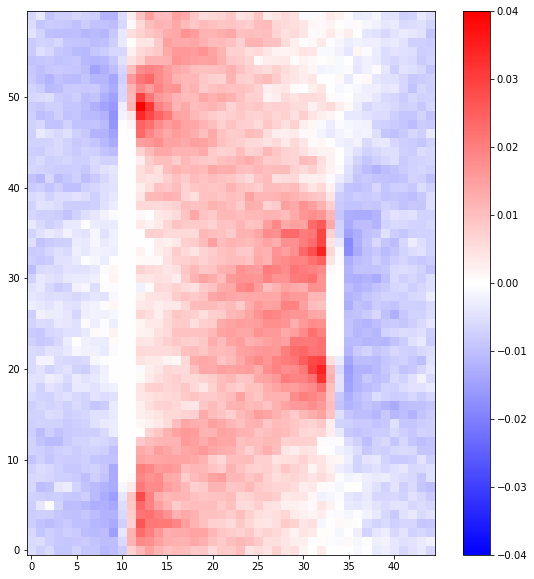

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(final_matrix[:,:,:,0,0].mean(axis=0), 
           origin='lower', cmap=plt.cm.bwr,
           vmin=-0.04, vmax=0.04, interpolation='none')
plt.colorbar()
plt.show()